<a href="https://colab.research.google.com/github/ARA-creator/SentimentElectionPrediction_DP/blob/master/LR_dp_sgd_eps_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pip install --upgrade tensorflow-privacy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 323.2/323.2 kB 16.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.8/104.8 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.0/442.0 kB 27.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 62.4 MB/s eta 0:00:00
  Attempting uninstall: tensorflow-probability
    Found existing installation: tensorflow-probability 0.24.0
    Uninstalling tensorflow-probability-0.24.0:
      Successfully uninstalled tensorflow-probability-0.24.0
  Attempting uninstall: packaging
    Found existing installation: packaging 24.2
    Uninstalling packaging-24.2:
      Successfully uninstalled packaging-24.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
langchain-core 0.3.21 requires packaging<25,>=23

In [ ]:
pip install tensorflow==2.14

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 489.8/489.8 MB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 40.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 38.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 50.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.7/440.7 kB 16.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 5.9 MB/s eta 0:00:00
  Attempting uninstall: wrapt
    Found existing installation: wrapt 1.17.0
    Uninstalling wrapt-1.17.0:
      Successfully uninstalled wrapt-1.17.0
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.15.0
    Uninstalling tensorflow-estimator-2.15.0:
      Successfully uninstalled tensorflow-estimator-2.15.0
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.4.1
    Uninstalling ml-dtypes-0.4.1:
      Successfully uninstalled ml-dtypes-0.4.1
  At

In [ ]:
import os
import warnings
warnings.filterwarnings('ignore')

# Core Libraries
import numpy as np
import pandas as pd
import scipy.sparse

# Visualization Libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning Libraries
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, precision_recall_curve, f1_score, roc_curve
from sklearn.utils.class_weight import compute_class_weight

# TensorFlow and Keras Libraries
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input, Layer
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from tensorflow.keras.utils import to_categorical
from tensorflow_privacy.privacy.optimizers.dp_optimizer_keras import DPKerasSGDOptimizer
from keras.saving import register_keras_serializable
from keras.optimizers import Optimizer

# DP Accounting Libraries
from dp_accounting.rdp import RdpAccountant
from dp_accounting import dp_event

# Mapping Dictionaries for Sentiment and Candidate Labels
sentiment_mapping = {0: 'Negative', 2: 'Neutral', 1: 'Positive'}
candidate_mapping = {0: 'BIDEN', 1: 'TRUMP'}

In [ ]:
# Custom Sparse-Dense Matrix Multiplication Layer
class SparseDenseMatMulLayer(Layer):
    def __init__(self, output_dim):
        super(SparseDenseMatMulLayer, self).__init__()
        self.output_dim = output_dim

    def build(self, input_shape):
        self.dense_weights = self.add_weight(
            name='dense_weights',
            shape=(input_shape[-1], self.output_dim),
            initializer='random_normal',
            trainable=True
        )

    def call(self, inputs):
        return tf.sparse.sparse_dense_matmul(inputs, self.dense_weights)

In [ ]:
# Data Generator
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, X, y, batch_size=32, shuffle=True):
        self.X = X
        self.y = to_categorical(y, num_classes=3)
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indices = np.arange(self.X.shape[0])
        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(self.X.shape[0] / self.batch_size))

    def __getitem__(self, index):
        start_index = index * self.batch_size
        end_index = (index + 1) * self.batch_size
        batch_X = self.X[start_index:end_index]
        batch_y = self.y[start_index:end_index]

        # Handle padding for last batch if it's smaller than batch size
        if batch_X.shape[0] < self.batch_size:
            padding_size = self.batch_size - batch_X.shape[0]
            padding_matrix = scipy.sparse.csr_matrix((padding_size, batch_X.shape[1]))
            batch_X = scipy.sparse.vstack([batch_X, padding_matrix])
            batch_y = np.vstack([batch_y, np.zeros((padding_size, batch_y.shape[1]))])

        # Convert batch_X to COO format (Coordinate format)
        batch_X_coo = batch_X.tocoo()

        # Create SparseTensor from COO representation
        batch_X_sparse = tf.sparse.SparseTensor(
            indices=np.vstack((batch_X_coo.row, batch_X_coo.col)).T,  # Stack row and column indices
            values=batch_X_coo.data,  # Non-zero values
            dense_shape=batch_X_coo.shape  # Shape of the original matrix
        )

        # Reorder indices to ensure correct ordering
        batch_X_sparse = tf.sparse.reorder(batch_X_sparse)

        return batch_X_sparse, batch_y

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indices)
            self.X = self.X[self.indices]
            self.y = self.y[self.indices]

In [ ]:
@register_keras_serializable(package='CustomPackage', name='DPOptimizerClass')
class DPOptimizerClass(Optimizer):
    def __init__(self, param1, param2, name="DPOptimizerClass", **kwargs):
        super().__init__(name=name, **kwargs)
        self.param1 = param1
        self.param2 = param2

    def get_config(self):
        config = super().get_config()
        config.update({
            'param1': self.param1,
            'param2': self.param2
        })
        return config

    def _create_slots(self, var_list):
        pass

    def _resource_apply_dense(self, grad, var, apply_state=None):
        pass

In [ ]:
# Mapping and Display Functions
def map_labels(df, candidate_col='Candidate', sentiment_col='Predicted Sentiment'):
    df[candidate_col] = df[candidate_col].map(candidate_mapping)
    df[sentiment_col] = df[sentiment_col].map(sentiment_mapping)
    return df

In [ ]:
def display_sentiment_counts(trump_biden_df, title):
    trump_biden_df = map_labels(trump_biden_df.copy(), candidate_col='Candidate', sentiment_col='Predicted Sentiment')
    sentiment_counts = trump_biden_df.groupby(['Candidate', 'Predicted Sentiment']).size().unstack(fill_value=0)

    # Print the sentiment counts for reference
    print(f"{title}:\n", sentiment_counts)

    # Call the new plot function
    plot_individual_sentiments(sentiment_counts, title, adjusted=True)  # Adjusted=True excludes neutral

In [ ]:
def display_original_sentiment_counts(trump_biden_df):
    original_df = trump_biden_df.copy()
    original_df = map_labels(original_df, candidate_col='Candidate', sentiment_col='sentiment')  # Map candidate names
    sentiment_counts = original_df.groupby(['Candidate', 'sentiment']).size().unstack(fill_value=0)
    print("Original Sentiment Counts:")
    print(sentiment_counts)
    plot_individual_sentiments(sentiment_counts, 'Sentiment Distribution Per Candidate')

In [ ]:
# Data Loading and Preprocessing
def preprocess_and_vectorize_chunks(file_path, max_features=5000, chunksize=1000):
    chunk_list = []
    sentiment_mapping = {'positive': 1, 'negative': 0, 'neutral': 2}

    for chunk in pd.read_csv(file_path, chunksize=chunksize):
        chunk = chunk[['preprocessed_tweet', 'Candidate', 'sentiment']]
        chunk.dropna(subset=['preprocessed_tweet', 'Candidate', 'sentiment'], inplace=True)
        chunk = chunk[chunk['sentiment'].isin(sentiment_mapping.keys())]
        chunk['sentiment'] = chunk['sentiment'].map(sentiment_mapping)
        chunk['Candidate'] = chunk['Candidate'].apply(lambda x: 1 if x == 'TRUMP' else 0)
        chunk_list.append(chunk)

    trump_biden_df = pd.concat(chunk_list, axis=0)

    tfidf_vectorizer = TfidfVectorizer(max_features=max_features)
    X = tfidf_vectorizer.fit_transform(trump_biden_df['preprocessed_tweet'])
    y = trump_biden_df['sentiment'].values
    candidate = trump_biden_df['Candidate'].values

    return X, y, candidate, tfidf_vectorizer, trump_biden_df

In [ ]:
from sklearn.model_selection import train_test_split

def build_multi_class_dpsgd_model(input_dim, num_classes, noise_multiplier, batch_size):
    # Define sparse input tensor
    inputs = Input(shape=(input_dim,), sparse=True)  # Input remains sparse

    # Use the custom SparseDenseMatMulLayer to handle sparse-dense multiplication
    sparse_dense_layer = SparseDenseMatMulLayer(output_dim=num_classes)(inputs)

    # Apply the activation function
    output_layer = Dense(num_classes, activation='softmax')(sparse_dense_layer)

    # Model creation
    model = Model(inputs=inputs, outputs=output_layer)

    # Differential Privacy Optimizer
    optimizer = DPKerasSGDOptimizer(
        l2_norm_clip=1.0,
        noise_multiplier=noise_multiplier,
        num_microbatches=batch_size,
        learning_rate=0.01
    )

    # Use CategoricalCrossentropy with no reduction to handle DP-SGD
    loss = tf.keras.losses.CategoricalCrossentropy(reduction=tf.keras.losses.Reduction.NONE)

    # Compile the model
    model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

    return model

In [ ]:
from tensorflow.keras.callbacks import Callback

class LearningRateLogger(Callback):
    def on_epoch_end(self, epoch, logs=None):
        # Log the current learning rate
        lr = self.model.optimizer.learning_rate.numpy()
        print(f" - learning_rate: {lr:.4f}")

In [ ]:

def train_model(model, data_generator, validation_data_generator, epochs, history_file=None):
    # Create callbacks with verbose logging
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=0.00001, verbose=1)
    checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True, verbose=1)
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)
    lr_logger = LearningRateLogger()  # Custom callback to log learning rate

    # Training with verbose logging
    history = model.fit(
        data_generator,
        epochs=epochs,
        validation_data=validation_data_generator,
        steps_per_epoch=len(data_generator),
        validation_steps=len(validation_data_generator),
        callbacks=[reduce_lr, checkpoint, early_stopping, lr_logger],
        verbose=1  # This will give progress bar and other detailed output per step
    )

    # Save history to CSV if specified
    if history_file:
        directory = os.path.dirname(history_file)
        if not os.path.exists(directory):
            os.makedirs(directory)
        hist_df = pd.DataFrame(history.history)
        if not hist_df.empty:
            hist_df.to_csv(history_file, index=False)

    best_model_file = 'best_model.keras'
    return history, best_model_file

In [ ]:
def compute_class_weights(y_train):
    class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
    return dict(enumerate(class_weights))

In [ ]:
def train_validation_test_split(X, y, candidate, test_size=0.1, val_size=0.1, random_state=42):
    # Step 1: Split into train+val and test sets
    X_train_val, X_test, y_train_val, y_test, candidate_train_val, candidate_test = train_test_split(
        X, y, candidate, test_size=test_size, random_state=random_state)

    # Step 2: Calculate adjusted validation size relative to the train+val set
    val_adjusted_size = val_size / (1 - test_size)  # Adjust the validation size based on the remaining data

    # Step 3: Split the train+val set into train and validation sets
    X_train, X_val, y_train, y_val, candidate_train, candidate_val = train_test_split(
        X_train_val, y_train_val, candidate_train_val, test_size=val_adjusted_size, random_state=random_state)

    return X_train, X_val, X_test, y_train, y_val, y_test, candidate_train, candidate_val, candidate_test

In [ ]:
# Additional Helper Functions
def save_history_to_csv(history, history_file):
    # Create necessary directories if they don't exist
    os.makedirs(os.path.dirname(history_file), exist_ok=True)
    pd.DataFrame(history.history).to_csv(history_file, index=False)

In [ ]:
def count_sentiments(trump_biden_df, candidate_column='Candidate', sentiment_column='sentiment'):
    sentiment_counts = trump_biden_df.groupby([candidate_column, sentiment_column]).size().unstack(fill_value=0)
    return sentiment_counts

In [ ]:
def plot_individual_sentiments(sentiment_counts, title, adjusted=False):
    # Map candidate indices to names
    candidates = ['BIDEN', 'TRUMP']
    index = np.arange(len(candidates))  # Create an index for each candidate

    # Extract sentiment counts (assume the DataFrame has columns: Negative, Neutral, Positive)
    # Access sentiment counts by column names, not numerical index
    negative = sentiment_counts['Negative'].values  # Negative sentiment
    neutral = sentiment_counts['Neutral'].values if 'Neutral' in sentiment_counts else np.zeros(len(candidates)) # Neutral sentiment (optional if adjusted)
    positive = sentiment_counts['Positive'].values  # Positive sentiment

    bar_width = 0.25  # Width of each bar

    plt.figure(figsize=(10, 6))  # Set the figure size
    plt.bar(index, negative, bar_width, label='Negative', color='navy')  # Plot negative sentiments
    if not adjusted and 'Neutral' in sentiment_counts:  # Include neutral if not adjusted and if the column is there
        plt.bar(index + bar_width, neutral, bar_width, label='Neutral', color='gray')  # Plot neutral sentiments
    plt.bar(index + (bar_width if adjusted or 'Neutral' not in sentiment_counts else 2 * bar_width), positive, bar_width, label='Positive', color='gold')  # Plot positive sentiments

    # Adding labels, title, and legend
    plt.xlabel('Candidate')
    plt.ylabel('Number of Tweets')
    plt.title(title)
    plt.xticks(index + bar_width, candidates)  # Set x-ticks at the center of grouped bars
    plt.legend()

    plt.tight_layout()  # Ensure layout fits into the figure area
    plt.show()

In [ ]:
def plot_training_history(history):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss', color='navy')
    plt.plot(history.history['val_loss'], label='Validation Loss', color='gold')
    plt.title('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Train Accuracy', color='navy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='gold')
    plt.title('Accuracy')
    plt.legend()

    plt.show()

In [ ]:
# Inside the evaluate_and_plot_metrics function:
from sklearn.metrics import classification_report, roc_curve, roc_auc_score

def evaluate_and_plot_metrics(model, X_test, y_test, roc_curve_file):
    # Create directory if it does not exist
    os.makedirs(os.path.dirname(roc_curve_file), exist_ok=True)
    X_test_coo = X_test.tocoo()

    # Create SparseTensor from COO representation
    X_test_sparse = tf.sparse.SparseTensor(
        indices=np.vstack((X_test_coo.row, X_test_coo.col)).T,
        values=X_test_coo.data,
        dense_shape=X_test_coo.shape
    )

    # Reorder indices to ensure correct ordering
    X_test_sparse = tf.sparse.reorder(X_test_sparse)

    # Make predictions with the sparse input
    y_pred = model.predict(X_test_sparse)

    # Convert y_test to integer labels if it’s one-hot encoded
    if y_test.ndim > 1 and y_test.shape[1] > 1:
        y_test_labels = np.argmax(y_test, axis=1)  # Convert one-hot to labels if necessary
    else:
        y_test_labels = y_test  # Already in label format

    # Convert y_pred to integer labels by taking argmax along last axis
    y_pred_labels = np.argmax(y_pred, axis=1)

    # Debugging checks
    print(f"y_test_labels shape: {y_test_labels.shape}, unique values: {np.unique(y_test_labels)}")
    print(f"y_pred_labels shape: {y_pred_labels.shape}, unique values: {np.unique(y_pred_labels)}")

    # Now you can safely calculate metrics
    target_names = [sentiment_mapping[i] for i in range(3)]
    print("\nClassification Report:\n", classification_report(y_test_labels, y_pred_labels, target_names=target_names))

    # Plot the confusion matrix
    cm = confusion_matrix(y_test_labels, y_pred_labels)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.title('Confusion Matrix')
    plt.show()

    # Compute ROC curves and AUC
    fpr, tpr, roc_auc = {}, {}, {}
    colors = ['gold', 'navy', 'grey']  # Colors for ROC curves
    for i, label in enumerate(target_names):
        fpr[i], tpr[i], _ = roc_curve((y_test_labels == i).astype(int), y_pred[:, i])
        roc_auc[i] = roc_auc_score((y_test_labels == i).astype(int), y_pred[:, i])

    # Plot ROC curves with specified colors
    plt.figure(figsize=(10, 8))
    for i, (label, color) in enumerate(zip(target_names, colors)):
        plt.plot(fpr[i], tpr[i], color=color, lw=2, label=f'{label} (area = {roc_auc[i]:0.2f})')
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve by Class')
    plt.legend(loc="lower right")
    plt.show()

    # Plot overall ROC curve (macro-average)
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(len(target_names))]))
    mean_tpr = np.zeros_like(all_fpr)

    # Average TPR for each class
    for i in range(len(target_names)):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

    mean_tpr /= len(target_names)
    overall_auc = np.trapz(mean_tpr, all_fpr)

    # Customized plot for the overall ROC curve with a square/step appearance
    plt.figure(figsize=(6, 6))  # Square figure size
    plt.step(all_fpr, mean_tpr, color='blue', lw=2, where='post', label=f'Macro-average (area = {overall_auc:0.2f})')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=1)  # Diagonal line for random guessing
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.title('Overall ROC Curve (Macro-average)', fontsize=14, fontweight='bold')
    plt.legend(loc="lower right", fontsize=10)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.tight_layout()  # Adjust layout to fit all elements well
    plt.show()

    # Save overall ROC curve data to CSV
    roc_data = pd.DataFrame({'fpr': all_fpr, 'tpr': mean_tpr})
    roc_data.to_csv(roc_curve_file, index=False)
    print(f"ROC data saved to {roc_curve_file}")

    # Calculate and display accuracy

    accuracy = accuracy_score(y_test_labels, y_pred_labels)
    print(f"Test Accuracy: {accuracy * 100:.2f}%")

    return accuracy, y_pred

In [ ]:
def extract_polling_shares(polling_data):
    """
    Extracts raw polling shares for Trump, Biden, and Others,
    and normalizes them to ensure the total is 100%.
    """
    # Ensure required columns are present
    required_columns = ['candidate_name', 'pct']
    for col in required_columns:
        if col not in polling_data.columns:
            raise ValueError(f"Missing required column: {col}")

    # Extract raw polling percentages
    trump_polling = polling_data.loc[polling_data['candidate_name'] == 'Donald Trump', 'pct'].mean()
    biden_polling = polling_data.loc[polling_data['candidate_name'] == 'Joe Biden', 'pct'].mean()
    others_polling = polling_data.loc[polling_data['candidate_name'] == 'Other Candidates', 'pct'].mean()

    # Handle missing values
    trump_polling = trump_polling if not np.isnan(trump_polling) else 0
    biden_polling = biden_polling if not np.isnan(biden_polling) else 0
    others_polling = others_polling if not np.isnan(others_polling) else 0

    # Sum of all raw percentages
    total_polling = trump_polling + biden_polling + others_polling

    # Normalize percentages to ensure total is 100%
    if total_polling > 0:
        normalized_trump = (trump_polling / total_polling) * 100
        normalized_biden = (biden_polling / total_polling) * 100
        normalized_others = (others_polling / total_polling) * 100
    else:
        normalized_trump = normalized_biden = normalized_others = 0

    return normalized_trump, normalized_biden, normalized_others

In [ ]:
# Redistribution of Neutral Sentiments
def redistribute_neutral_dp(y_pred_labels, candidate_labels, epsilon= 1):
    """
    Redistributes neutral sentiments with DP-based proportionality for DP-SGD predictions.
    """
    redistributed_predictions = np.copy(y_pred_labels)
    for candidate in np.unique(candidate_labels):
        candidate_mask = candidate_labels == candidate
        neutral_indices = np.where((candidate_mask) & (y_pred_labels == 2))[0]
        if len(neutral_indices) > 0:
            np.random.shuffle(neutral_indices)
            positives = sum((y_pred_labels[candidate_mask] == 1))
            negatives = sum((y_pred_labels[candidate_mask] == 0))
            total_decided = positives + negatives

            if total_decided > 0:
                sensitivity = 1.0 / total_decided
                noise = np.random.laplace(loc=0, scale=sensitivity / epsilon)
                positive_ratio = positives / total_decided + noise
                positive_ratio = np.clip(positive_ratio, 0.01, 0.99)

                redistributed_to_positive = int(len(neutral_indices) * positive_ratio)
                redistributed_predictions[neutral_indices[:redistributed_to_positive]] = 1
                redistributed_predictions[neutral_indices[redistributed_to_positive:]] = 0
    return redistributed_predictions

In [ ]:
def calculate_adjusted_sentiment_share(adjusted_df, candidate_val):
    # Use 'Predicted Sentiment' instead of 'sentiment'
    positive_count = np.sum((adjusted_df['Candidate'] == candidate_val) & (adjusted_df['Predicted Sentiment'] == 2))
    total_count = np.sum(adjusted_df['Candidate'] == candidate_val)

    positive_share = positive_count / total_count if total_count > 0 else 0
    return positive_share

In [ ]:
# DP-Based Scaling Adjustments
def scale_sentiment_shares_with_dp(sentiment_share, epsilon= 1):
    """
    Applies a DP-based random scaling to sentiment shares to introduce variability.
    """
    sensitivity = 0.05  # Small adjustment to maintain accuracy
    noise = np.random.laplace(loc=0, scale=sensitivity / epsilon)
    adjusted_share = sentiment_share + noise
    return np.clip(adjusted_share, 0, 1)

In [ ]:
# Election Prediction Logic
def predict_election_with_dp_adjustments(
    positive_share_trump, positive_share_biden, polling_data, others_cap=2.0, epsilon= 1, beta=0.8
):
    """
    Predicts the election outcome with DP-adjusted decay for 'Others' share.
    """
    # Apply DP-based scaling to sentiment shares
    positive_share_trump = scale_sentiment_shares_with_dp(positive_share_trump, epsilon)
    positive_share_biden = scale_sentiment_shares_with_dp(positive_share_biden, epsilon)

    # Combine sentiment shares with polling data
    trump_score = (0.9 * polling_data['trump_polling']) + (1 * positive_share_trump)
    biden_score = (0.9 * polling_data['biden_polling']) + (1 * positive_share_biden)

    # Apply DP-integrated decay to 'Others'
    sensitivity = 0.05  # Sensitivity for DP noise
    dp_noise = np.random.laplace(loc=0, scale=sensitivity / epsilon)
    others_score = polling_data['others_polling'] * beta + dp_noise

    # Cap 'Others' share and redistribute the excess
    if others_score > others_cap:
        excess_others = others_score - others_cap
        total_major = trump_score + biden_score
        if total_major > 0:
            redistribution_ratio_trump = trump_score / total_major
            redistribution_ratio_biden = biden_score / total_major
            trump_score += excess_others * redistribution_ratio_trump
            biden_score += excess_others * redistribution_ratio_biden
        others_score = others_cap

    # Normalize scores to ensure they sum to 100%
    total = trump_score + biden_score + others_score
    trump_score = (trump_score / total) * 100
    biden_score = (biden_score / total) * 100
    others_score = (others_score / total) * 100

    winner = 'TRUMP' if trump_score > biden_score else 'BIDEN'

    return trump_score, biden_score, others_score, winner

In [ ]:
def plot_sentiment_vs_polling(trump_score, biden_score, winner):
    # Define candidates and their scores
    candidates = ['TRUMP', 'BIDEN', 'OTHERS']
    others_score = 100 - trump_score - biden_score
    scores = [trump_score, biden_score, others_score]
    colors = ['navy', 'gold', 'gray']

    # Create a bar chart
    plt.figure(figsize=(10, 6))
    bars = plt.bar(candidates, scores, color=colors, edgecolor='black', alpha=0.8)

    # Add text labels above each bar
    for bar, score in zip(bars, scores):
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 1,
                 f"{score:.2f}%", ha='center', va='bottom', fontsize=12)

    # Customize the chart
    plt.ylabel('Score (%)', fontsize=14)
    plt.xlabel('Candidates', fontsize=14)
    plt.title(f'Predicted Election Outcome ({winner} Wins)', fontsize=16, fontweight='bold')
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.ylim(0, 100)  # Ensure y-axis is scaled from 0 to 100
    plt.grid(axis='y', linestyle='--', alpha=0.7)  # Add gridlines for y-axis

    # Show the plot
    plt.tight_layout()
    plt.show()

In [ ]:
def compute_privacy_budget(num_samples, batch_size, noise_multiplier, epochs, delta):
    steps_per_epoch = int(np.ceil(num_samples / batch_size))
    total_steps = int(steps_per_epoch * epochs)

    orders = [1 + x / 10. for x in range(1, 100)] + list(range(12, 128))

    accountant = RdpAccountant(orders=orders)

    dp_sgd_event = dp_event.PoissonSampledDpEvent(
        sampling_probability=batch_size / num_samples,
        event=dp_event.GaussianDpEvent(noise_multiplier)
    )

    accountant.compose(dp_sgd_event, total_steps)

    epsilons = accountant.get_epsilon(delta)

    if isinstance(epsilons, (list, np.ndarray)):
        optimal_order_index = np.argmin(epsilons)
        optimal_order = orders[optimal_order_index]
        optimal_epsilon = epsilons[optimal_order_index]
    else:
        optimal_order = orders[0]
        optimal_epsilon = epsilons

    sampling_rate = batch_size / num_samples
    sampling_rate_formatted = f"{sampling_rate * 100:.5f}%"

    privacy_report = (
        f"DP-SGD with sampling rate = {sampling_rate_formatted} and noise_multiplier = {noise_multiplier:.3f} "
        f"iterated over {total_steps} steps satisfies differential privacy with eps = {optimal_epsilon:.1f} "
        f"and delta = {delta:.0e}.\n"
        f"The optimal RDP order is {optimal_order}.\n"
        f"({optimal_epsilon}, {optimal_order})"
    )

    return optimal_epsilon, optimal_order, privacy_report

In [ ]:
def find_noise_multiplier_for_exact_epsilon(target_epsilon, num_samples, batch_size, epochs, delta, tolerance=0.00001):
    # Initialize the lower and upper bounds for the noise multiplier
    lower_bound = 0.01
    upper_bound = 5.0
    noise_multiplier = (lower_bound + upper_bound) / 2  # Start with the midpoint

    while upper_bound - lower_bound > tolerance:
        # Calculate the epsilon for the current noise multiplier
        epsilon, _, _ = compute_privacy_budget(num_samples, batch_size, noise_multiplier, epochs, delta)

        # If the epsilon is exactly target_epsilon, return the current noise multiplier
        if abs(epsilon - target_epsilon) <= tolerance:
            break

        # If epsilon is greater than the target, increase the noise multiplier
        if epsilon > target_epsilon:
            lower_bound = noise_multiplier
        # If epsilon is less than the target, decrease the noise multiplier
        else:
            upper_bound = noise_multiplier

        # Update noise_multiplier as the new midpoint
        noise_multiplier = (lower_bound + upper_bound) / 2

    return noise_multiplier

Original Sentiment Counts:
sentiment  Negative  Neutral  Positive
Candidate                             
BIDEN         78502    84573    152159
TRUMP        157293   116426    154887


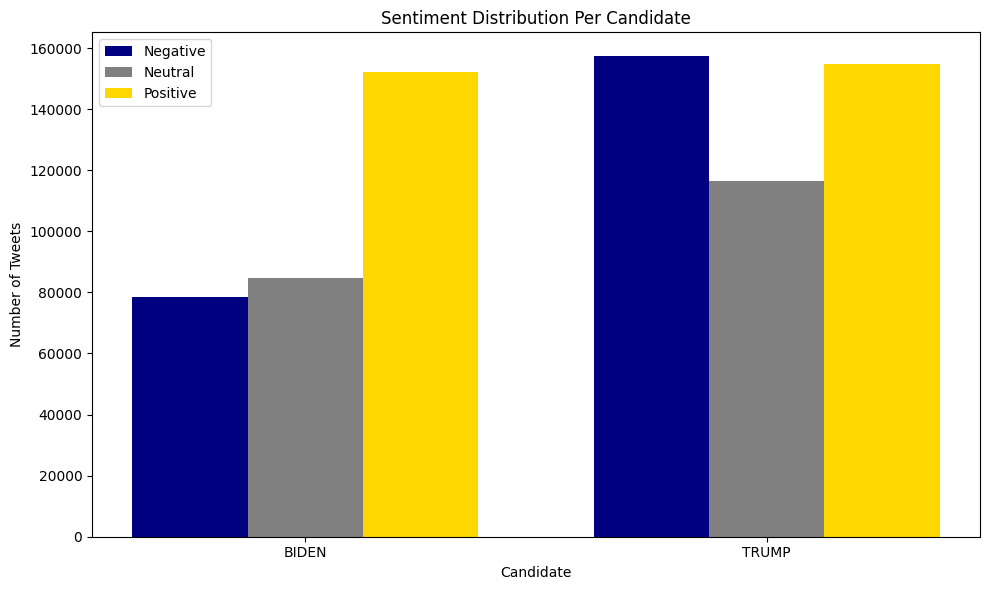

Epoch 1/100
18590/18596 [============================>.] - ETA: 0s - loss: 1.0241 - accuracy: 0.4808
Epoch 1: val_loss improved from inf to 0.92021, saving model to best_model.h5
18596/18596 [==============================] - 183s 10ms/step - loss: 1.0241 - accuracy: 0.4809 - val_loss: 0.9202 - val_accuracy: 0.5800 - lr: 0.0100
Epoch 2/100
18594/18596 [============================>.] - ETA: 0s - loss: 0.8434 - accuracy: 0.6149
Epoch 2: val_loss improved from 0.92021 to 0.79015, saving model to best_model.h5
18596/18596 [==============================] - 181s 10ms/step - loss: 0.8434 - accuracy: 0.6149 - val_loss: 0.7902 - val_accuracy: 0.6455 - lr: 0.0100
Epoch 3/100
18595/18596 [============================>.] - ETA: 0s - loss: 0.7609 - accuracy: 0.6693
Epoch 3: val_loss improved from 0.79015 to 0.73993, saving model to best_model.h5
18596/18596 [==============================] - 180s 10ms/step - loss: 0.7608 - accuracy: 0.6693 - val_loss: 0.7399 - val_accuracy: 0.6849 - lr: 0.0100
Ep

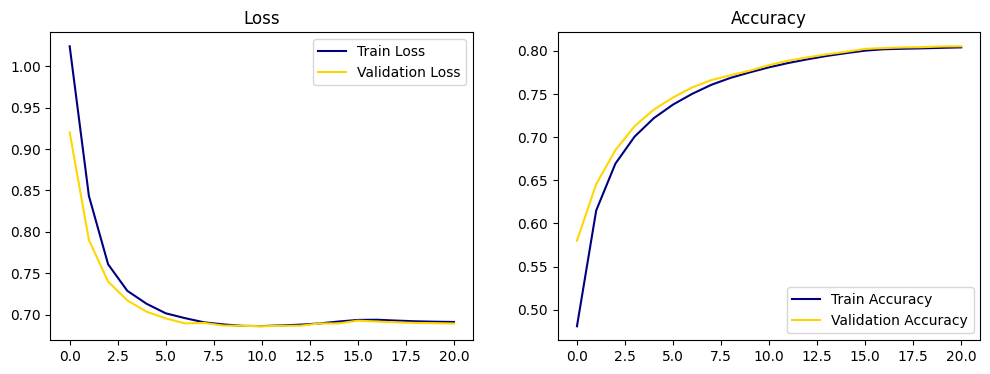

2325/2325 [==============================] - 3s 1ms/step
y_test_labels shape: (74384,), unique values: [0 1 2]
y_pred_labels shape: (74384,), unique values: [0 1 2]

Classification Report:
               precision    recall  f1-score   support

    Negative       0.78      0.73      0.75     23677
    Positive       0.83      0.80      0.81     30703
     Neutral       0.73      0.82      0.77     20004

    accuracy                           0.78     74384
   macro avg       0.78      0.78      0.78     74384
weighted avg       0.79      0.78      0.78     74384



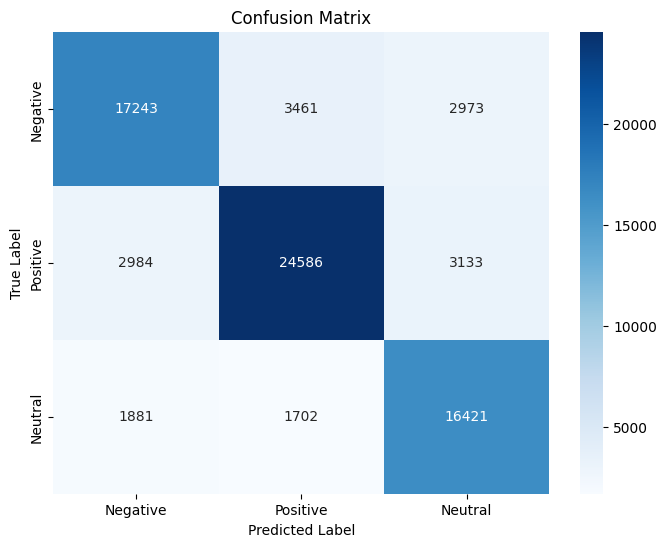

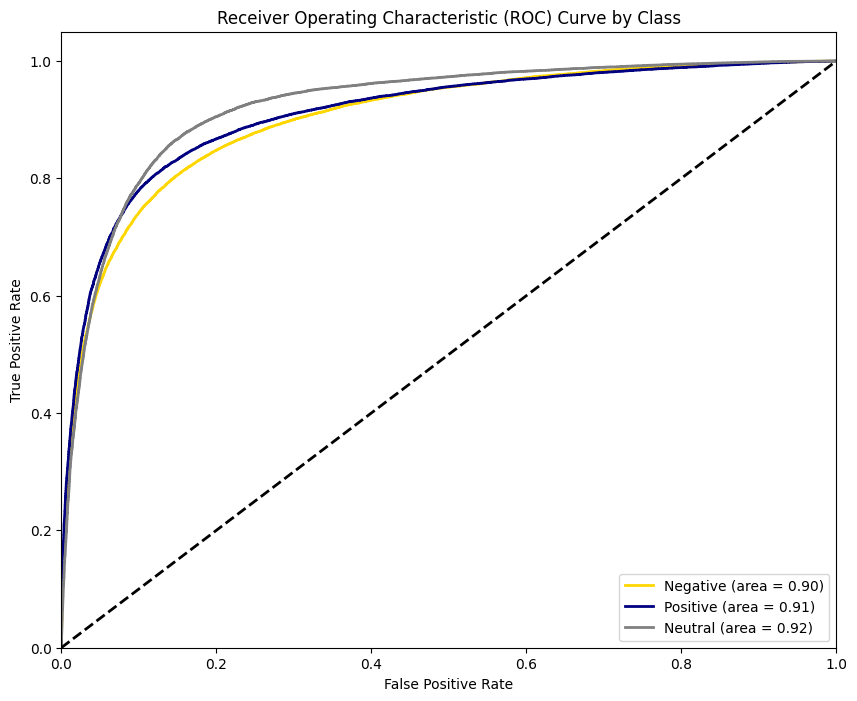

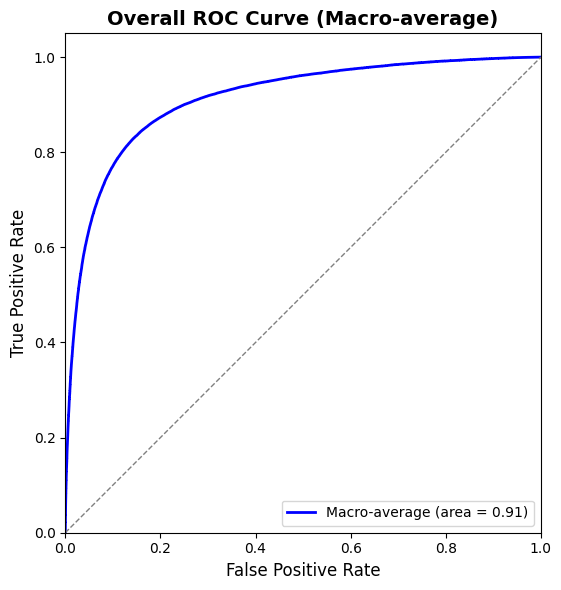

ROC data saved to /content/drive/MyDrive/models/histories/dp_models/roc_curve/LR_dp-sgd_eps-1
Test Accuracy: 78.31%
Adjusted Sentiment Distribution (Neutral Redistributed):
 Predicted Sentiment  Negative  Positive
Candidate                              
BIDEN                   10185     21362
TRUMP                   21485     21352


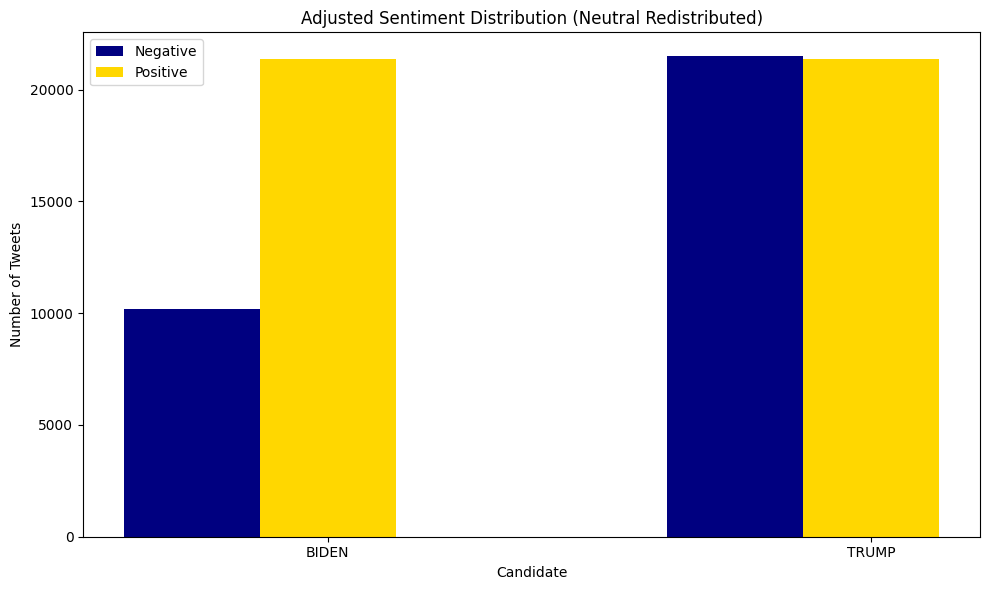

Trump Polling: 36.97%, Biden Polling: 41.46%, Others Polling: 21.57%
Predicted Results:
Trump: 46.09%, Biden: 51.63%, Others: 2.28%
Predicted Winner: BIDEN


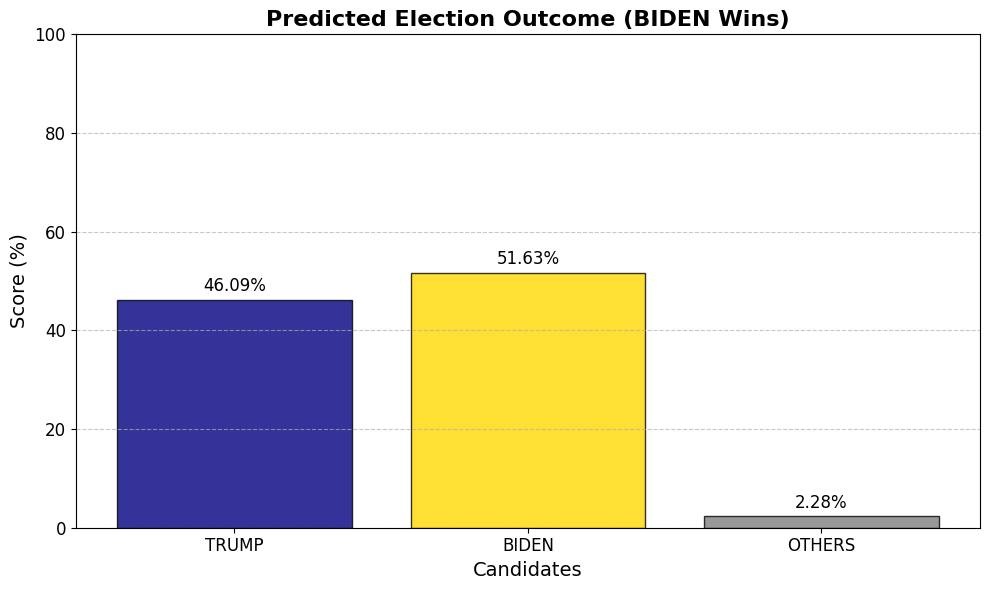

Privacy budget (epsilon): 1.0000829957030577
DP-SGD with sampling rate = 0.00538% and noise_multiplier = 0.830 iterated over 1859600 steps satisfies differential privacy with eps = 1.0 and delta = 2e-06.
The optimal RDP order is 1.1.
(1.0000829957030577, 1.1)


In [ ]:
# Main Function
def main():
    file_path = '/content/drive/MyDrive/preprocessed_datasets/1_1_filtered_trump_biden_df.csv'
    polling_data_path = '/content/drive/MyDrive/preprocessed_datasets/preprocessed_poll_data.csv'
    polling_data = pd.read_csv(polling_data_path)

    max_features = 5000
    chunksize = 1000

    X, y, candidate, tfidf_vectorizer, trump_biden_df = preprocess_and_vectorize_chunks(file_path, max_features=max_features, chunksize=chunksize)

    # Plot the original sentiment distribution
    display_original_sentiment_counts(trump_biden_df)

    X_train, X_val, X_test, y_train, y_val, y_test, candidate_train, candidate_val, candidate_test = train_validation_test_split(
    X, y, candidate, test_size=0.1, val_size=0.1, random_state=42)

    input_dim = X_train.shape[1]
    num_classes = 3
    batch_size = 32
    epochs = 100
    num_samples = X_train.shape[0]
    delta = 1 / num_samples
    target_epsilon = 1

    optimal_noise_multiplier = find_noise_multiplier_for_exact_epsilon(target_epsilon, num_samples, batch_size, epochs, delta)

    train_data_generator = DataGenerator(X_train, y_train, batch_size=batch_size)
    validation_data_generator = DataGenerator(X_val, y_val, batch_size=batch_size)

    device = '/device:GPU:0' if tf.config.list_physical_devices('GPU') else '/device:CPU:0'

    # Define and build the model before calling fit
    model = build_multi_class_dpsgd_model(input_dim, num_classes, optimal_noise_multiplier, batch_size)

# Callbacks
    # Correct checkpoint path with HDF5 format
    checkpoint_path = 'best_model.h5'

    # ModelCheckpoint with explicit format
    model_checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_loss', save_best_only=True, verbose=1, save_format='h5')

    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=0.00001, verbose=1)
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)

    # Define callbacks in a list
    callbacks = [reduce_lr, early_stopping, model_checkpoint]

    # Train the model
    # Train the model
    # Train the model
    history = model.fit(
        train_data_generator,
        validation_data=validation_data_generator,
        epochs=epochs,
        callbacks=[reduce_lr, model_checkpoint, early_stopping],  # Use corrected model_checkpoint
        verbose=1
    )

    history_file = '/content/drive/MyDrive/models/histories/dp_models/accuracy/LR_dp-sgd_eps-1.csv'
    save_history_to_csv(history, history_file)
    plot_training_history(history)

    roc_curve_file = '/content/drive/MyDrive/models/histories/dp_models/roc_curve/LR_dp-sgd_eps-1'
    accuracy, y_pred = evaluate_and_plot_metrics(model, X_test, y_test, roc_curve_file)

    # Redistribute neutral sentiments
    adjusted_y_pred_labels = redistribute_neutral_dp(np.argmax(y_pred, axis=1), candidate_test, epsilon=1)

    test_df = pd.DataFrame({'Candidate': candidate_test, 'True Sentiment': y_test, 'Predicted Sentiment': adjusted_y_pred_labels})
    display_sentiment_counts(test_df, 'Adjusted Sentiment Distribution (Neutral Redistributed)')

    # Calculate sentiment shares
    positive_share_trump = calculate_adjusted_sentiment_share(pd.DataFrame({'Candidate': candidate_test, 'Predicted Sentiment': adjusted_y_pred_labels}), 1)
    positive_share_biden = calculate_adjusted_sentiment_share(pd.DataFrame({'Candidate': candidate_test, 'Predicted Sentiment': adjusted_y_pred_labels}), 0)

    # Predict election results
    trump_polling, biden_polling, others_polling = extract_polling_shares(polling_data)
    print(f"Trump Polling: {trump_polling:.2f}%, Biden Polling: {biden_polling:.2f}%, Others Polling: {others_polling:.2f}%")

    # Predict election outcome with DP adjustments
    trump_score, biden_score, others_score, predicted_winner = predict_election_with_dp_adjustments(
        positive_share_trump, positive_share_biden,
        polling_data={'trump_polling': trump_polling, 'biden_polling': biden_polling, 'others_polling': others_polling}, others_cap= 2.0, beta=0.8, epsilon= 1
    )

    print(f"Predicted Results:\nTrump: {trump_score:.2f}%, Biden: {biden_score:.2f}%, Others: {others_score:.2f}%")
    print(f"Predicted Winner: {predicted_winner}")


        # Plot the predicted results
    plot_sentiment_vs_polling(trump_score, biden_score, predicted_winner)

    epsilon, optimal_order, privacy_report = compute_privacy_budget(num_samples, batch_size, optimal_noise_multiplier, epochs, delta)
    print(f'Privacy budget (epsilon): {epsilon}')
    print(privacy_report)

if __name__ == "__main__":
    main()